In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sqlalchemy import create_engine

# Postgres username, password, and database name
POSTGRES_ADDRESS = 'drona.db.elephantsql.com'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'drkctwgf'
POSTGRES_PASSWORD = 'CCs_bf9UxHgtUwP-EDVRmduuymmTQAss'
POSTGRES_DBNAME = 'drkctwgf'

# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME,
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME))

# Create the connection
cnx = create_engine(postgres_str)

# Joining Tables
After connecting and loading the data, filter the loans table for loans withdrawn, then merge with the transactions table using common keys, and then finally sorting by most recent on top.

In [3]:
users = pd.read_sql_query('''SELECT * FROM users;''', cnx)
users.head()

,id,created
0,105,2017-04-12 10:26
1,258,2017-10-27 21:00
2,167,2017-05-24 03:18
3,2247,2020-03-19 13:47
4,262,2017-10-27 13:40


In [4]:
loans = pd.read_sql_query('''SELECT * FROM loans;''', cnx)
loans.head()

,id,created,loan_status,user_id,amount
0,66,2017-04-08 19:22:00,repaid,1,240
1,181,2017-12-30 00:42:00,repaid,1,240
2,182,2017-12-30 01:54:00,repaid,1,240
3,132,2017-07-05 12:08:00,approved,211,240
4,183,2017-12-30 01:54:00,approved,1,240


In [5]:
transactions = pd.read_sql_query('''SELECT * FROM transactions;''', cnx)
transactions.head()

,transaction.id,created,loan_id,user_id,transaction_fee,t_type,transaction.amount
0,1530,2020-04-27,1863,2339.0,15,disbursement,316
1,1539,2020-04-28,1878,2339.0,8,disbursement,10
2,1546,2020-04-28,1885,2345.0,15,disbursement,316
3,1442,2020-03-30,1740,2214.0,8,disbursement,10
4,1523,2020-04-26,1857,2339.0,8,lodgement,116


In [6]:
# Filtering active and repaid loans
withdrawn = loans.loc[(loans.loan_status == "active") | (loans.loan_status == "repaid")].rename(columns = {'id': 'loan_id'})
withdrawn.head()

,loan_id,created,loan_status,user_id,amount
0,66,2017-04-08 19:22:00,repaid,1,240
1,181,2017-12-30 00:42:00,repaid,1,240
2,182,2017-12-30 01:54:00,repaid,1,240
5,71,2017-04-12 12:04:00,active,104,240
6,892,2019-05-02 07:40:00,active,105,240


In [7]:
new_loans = withdrawn.merge(transactions, on=["loan_id", 'user_id']).rename(columns = {'created_x': 'user.created'}).sort_values(by = 'user.created', ascending = False)
new_loans.head()

,loan_id,user.created,loan_status,user_id,amount,transaction.id,created_y,transaction_fee,t_type,transaction.amount
23,1857,2020-04-24 12:42:00,active,2339,316,1521,2020-04-24,8,lodgement,10
22,1857,2020-04-24 12:42:00,active,2339,316,1526,2020-04-27,8,lodgement,10
21,1857,2020-04-24 12:42:00,active,2339,316,1525,2020-04-27,8,lodgement,10
20,1857,2020-04-24 12:42:00,active,2339,316,1520,2020-04-24,15,disbursement,316
19,1857,2020-04-24 12:42:00,active,2339,316,1528,2020-04-27,8,lodgement,202


In [8]:
loans_final = new_loans[['loan_id', 'amount', 'user_id', 'user.created', 'transaction_fee', 't_type']]
loans_final

,loan_id,amount,user_id,user.created,transaction_fee,t_type
23,1857,316,2339,2020-04-24 12:42:00,8,lodgement
22,1857,316,2339,2020-04-24 12:42:00,8,lodgement
21,1857,316,2339,2020-04-24 12:42:00,8,lodgement
20,1857,316,2339,2020-04-24 12:42:00,15,disbursement
19,1857,316,2339,2020-04-24 12:42:00,8,lodgement
18,1857,316,2339,2020-04-24 12:42:00,8,lodgement
30,1812,316,2296,2020-04-15 15:20:00,15,disbursement
31,1736,316,2140,2020-03-29 15:24:00,15,disbursement
13,1533,316,2140,2020-01-29 17:08:00,22,disbursement
14,1533,316,2140,2020-01-29 17:08:00,15,refund


# Aggregation

In [9]:
loans['month'] = pd.DatetimeIndex(loans['created']).month
loans.head()

,id,created,loan_status,user_id,amount,month
0,66,2017-04-08 19:22:00,repaid,1,240,4
1,181,2017-12-30 00:42:00,repaid,1,240,12
2,182,2017-12-30 01:54:00,repaid,1,240,12
3,132,2017-07-05 12:08:00,approved,211,240,7
4,183,2017-12-30 01:54:00,approved,1,240,12


In [10]:
loans_per_month = loans.groupby('month')['id'].nunique()
loans_per_month = loans_per_month.rename('loans per month')

In [11]:
amount_per_month = loans.groupby('month')['amount'].sum()
amount_per_month = amount_per_month.rename('amount per month')

In [12]:
avg_loan_amount = round(amount_per_month / loans_per_month, 2)
avg_loan_amount = avg_loan_amount.rename('avg loan amount')

In [13]:
min_loan = loans.groupby('month')['amount'].min()
min_loan = min_loan.rename('min loan')

In [14]:
max_loan = loans.groupby('month')['amount'].max()
max_loan = max_loan.rename('max loan')

In [15]:
agg_loans = pd.concat([loans_per_month, amount_per_month, avg_loan_amount, min_loan, max_loan], axis=1).reset_index().sort_values('month', ascending = False)
agg_loans

,month,loans per month,amount per month,avg loan amount,min loan,max loan
9,12,3,720,240.00,240,240
8,11,1,440,440.00,440,440
7,10,2,640,320.00,240,400
6,8,2,480,240.00,240,240
5,7,1,240,240.00,240,240
4,5,3,880,293.33,240,400
3,4,15,2897,193.13,10,1000
2,3,10,1509,150.90,1,528
1,2,1,240,240.00,240,240
0,1,6,1908,318.00,200,528


# Data Analysis

In [16]:
weekly_logins = pd.read_sql_query('''SELECT * FROM weekly_logins;''', cnx)
weekly_logins = weekly_logins.sort_values('weekly_logins', ascending = False)
weekly_logins.head()

,user_name,slack_integration,most_used_page,had_free_trial,user_mrr,weekly_logins,company_name,industry,company_size,territory,sales_call_in_trial,zendesk_integration,salesforce_integration,gmail_integration,most_common_referrer,most_common_ip,sales_touches_to_close,used_admin_panel,has_issued_support_request
341,Paul Krupp,Yes,/tool/storyboard,Yes,169,17,Lucky Brand,Consumer Products,$100M - $500M,West,No,No,No,Yes,/slack.com,138.197.222.35,4,Yes,No
578,George Palmer,Yes,/tool/storyboard,Yes,39,17,SpaceX,Technology,$1B - $10B,West,No,Yes,No,No,/quora,174.138.54.49,9,No,No
452,Brigid Watson,No,/tool/storyboard,Yes,39,17,Siemon,Manufacturing,$100M - $500M,Midwest,No,No,Yes,Yes,hotels.com,192.200.200.99,14,Yes,Yes
1537,Evelyn Andrade,No,/tool/storyboard,Yes,169,17,Yahoo! Inc.,Technology,$1B - $10B,West,Yes,Yes,Yes,No,/tripadvisor.com,162.243.108.161,6,No,Yes
1267,Charlie Hurrell,No,/tool/storyboard,Yes,39,17,Visa,Technology,>$10B,West,No,Yes,Yes,Yes,/mail.google.com,198.199.120.102,6,No,Yes


In [17]:
pd.options.display.float_format = '{:.2%}'.format

In [18]:
for s in weekly_logins.columns[1:]:
    print(weekly_logins.groupby(s)['weekly_logins'].sum() / sum(weekly_logins['weekly_logins']))

slack_integration
No    57.21%
Yes   42.79%
Name: weekly_logins, dtype: float64
most_used_page
/dashboard           2.45%
/home                2.39%
/login               2.25%
/tool/build_query    2.43%
/tool/search         2.85%
/tool/storyboard    87.64%
Name: weekly_logins, dtype: float64
had_free_trial
No    40.95%
Yes   59.05%
Name: weekly_logins, dtype: float64
user_mrr
39     53.99%
169    36.27%
1299    9.74%
Name: weekly_logins, dtype: float64
weekly_logins
0     0.00%
1     0.58%
2     2.21%
3     7.08%
4     9.71%
5    11.90%
6    10.82%
7     8.06%
8     3.92%
9     4.32%
10    6.14%
11    5.38%
12    5.41%
13    7.48%
14    8.33%
15    4.61%
16    3.07%
17    0.98%
Name: weekly_logins, dtype: float64
company_name
HP                              3.96%
Huron Consulting Group          2.63%
Hushmail                        4.71%
InVision                        3.11%
LiveRamp                        3.96%
Lucky Brand                     4.30%
Lush                            1.54

What categories or groups here had high engagement (weekly logins) levels?
To find the high engagement categories and groups, I parsed the weekly_logins dataframe and grouped each iteration by the distinct values of an individual column. I then summed up the number of weekly logins for that particular instance and turned it into a percent out of total weekly logins. This way, we can compare each instance of a column with one another. From this, I found that the /tool/storyboard has a very high engagement level of 87%, compared to ~2% for all the other pages. Other areas of high engagement that stood out in its category include a user_mrr of 39 (54%), the technology industry (51%), $100M - $500M company size (46%), and the West (46%).

# Product Challenge

In [19]:
# Top 20% considered as high engagement
high_engagement = weekly_logins.head(int(len(weekly_logins)*.2))
high_engagement

,user_name,slack_integration,most_used_page,had_free_trial,user_mrr,weekly_logins,company_name,industry,company_size,territory,sales_call_in_trial,zendesk_integration,salesforce_integration,gmail_integration,most_common_referrer,most_common_ip,sales_touches_to_close,used_admin_panel,has_issued_support_request
341,Paul Krupp,Yes,/tool/storyboard,Yes,169,17,Lucky Brand,Consumer Products,$100M - $500M,West,No,No,No,Yes,/slack.com,138.197.222.35,4,Yes,No
578,George Palmer,Yes,/tool/storyboard,Yes,39,17,SpaceX,Technology,$1B - $10B,West,No,Yes,No,No,/quora,174.138.54.49,9,No,No
452,Brigid Watson,No,/tool/storyboard,Yes,39,17,Siemon,Manufacturing,$100M - $500M,Midwest,No,No,Yes,Yes,hotels.com,192.200.200.99,14,Yes,Yes
1537,Evelyn Andrade,No,/tool/storyboard,Yes,169,17,Yahoo! Inc.,Technology,$1B - $10B,West,Yes,Yes,Yes,No,/tripadvisor.com,162.243.108.161,6,No,Yes
1267,Charlie Hurrell,No,/tool/storyboard,Yes,39,17,Visa,Technology,>$10B,West,No,Yes,Yes,Yes,/mail.google.com,198.199.120.102,6,No,Yes
1202,Claudia Wilson,No,/tool/storyboard,Yes,169,17,Visa,Technology,>$10B,West,No,Yes,Yes,Yes,/facebook.com,198.199.120.102,5,Yes,No
1463,Matthew Jackson,No,/tool/storyboard,Yes,169,16,Worldsource Wealth Management,Finance,$100M - $500M,East,Yes,Yes,Yes,Yes,hotels.com,138.68.41.90,15,Yes,No
629,Debra Collier,Yes,/tool/storyboard,Yes,39,16,SpaceX,Technology,$1B - $10B,West,No,Yes,No,No,/google.com,159.203.166.41,8,Yes,Yes
50,Kim Brittain,No,/tool/storyboard,Yes,1299,16,HP,Technology,>$10B,West,Yes,Yes,Yes,Yes,/slack.com,159.203.166.41,13,No,No
626,Richard Scarpello,No,/tool/storyboard,Yes,39,16,SpaceX,Technology,$1B - $10B,West,No,Yes,Yes,No,/slack.com,138.68.240.218,14,No,No


In [20]:
# Bottom 80% considered as low engagement
low_engagement = weekly_logins.tail(int(len(weekly_logins)*.8))
low_engagement

,user_name,slack_integration,most_used_page,had_free_trial,user_mrr,weekly_logins,company_name,industry,company_size,territory,sales_call_in_trial,zendesk_integration,salesforce_integration,gmail_integration,most_common_referrer,most_common_ip,sales_touches_to_close,used_admin_panel,has_issued_support_request
645,Hubert Echols,No,/tool/storyboard,Yes,39,9,SpaceX,Technology,$1B - $10B,West,No,No,No,Yes,/slack.com,138.68.240.218,16,Yes,No
164,Colette Lindelof,Yes,/tool/storyboard,Yes,169,9,Hushmail,Technology,$100M - $500M,West,Yes,Yes,Yes,Yes,/slack.com,162.243.108.129,11,No,No
1324,Ronald Carroll,No,/tool/storyboard,Yes,39,9,Wal-Mart Stores,Other,>$10B,Midwest,Yes,Yes,Yes,Yes,/mail.google.com,72.35.40.34,14,No,No
1257,Rosanna Cox,Yes,/tool/storyboard,Yes,1299,9,Visa,Technology,>$10B,West,No,No,No,No,/quora,138.197.222.35,11,Yes,Yes
1112,Amy Atwood,Yes,/tool/build_query,Yes,39,9,Uniform Law Commission,Legal Services,<$100M,Midwest,No,Yes,Yes,No,/quora,162.243.108.161,8,Yes,No
644,James Wylie,Yes,/tool/storyboard,Yes,39,9,SpaceX,Technology,$1B - $10B,West,Yes,No,No,No,/google.com,191.96.42.80,15,No,No
1615,Alice Kelly,Yes,/tool/build_query,Yes,39,9,Zendesk,Technology,$500M - $1B,West,Yes,Yes,No,Yes,/quora,198.199.120.102,12,No,Yes
869,Jamie Jackson,Yes,/tool/storyboard,Yes,39,9,Twilio,Technology,$100M - $500M,West,No,Yes,Yes,Yes,hotels.com,138.68.240.218,14,No,Yes
396,Victor Lindsey,Yes,/tool/storyboard,Yes,39,9,Lush,Consumer Products,$100M - $500M,East,Yes,No,No,Yes,hotels.com,138.68.41.90,4,No,No
575,Peter Henson,Yes,/tool/storyboard,Yes,39,9,SpaceX,Technology,$1B - $10B,West,No,Yes,No,No,/quora,162.243.108.161,8,No,Yes


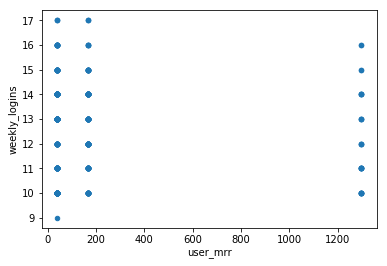

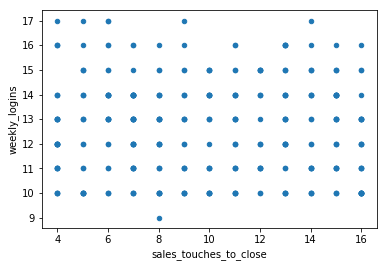

In [21]:
high_engagement.plot('user_mrr', 'weekly_logins', kind='scatter')
high_engagement.plot('sales_touches_to_close', 'weekly_logins', kind='scatter')

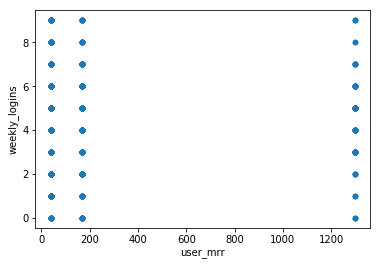

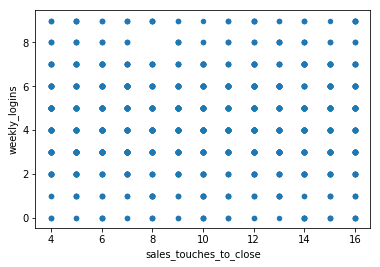

In [22]:
low_engagement.plot('user_mrr', 'weekly_logins', kind='scatter')
low_engagement.plot('sales_touches_to_close', 'weekly_logins', kind='scatter')

Based on the scatter plots, both user_mrr and sales_touches_to_close do not show a strong correlation with high engagement. Regardless if the user_mrr / sales_touches_to_close are low or high, they occur at the same rate in both the high and low engagement rate groups.

In [23]:
for s in high_engagement.columns[1:]:
    print(high_engagement.groupby(s)['user_name'].nunique() / len(high_engagement))

slack_integration
No    25.95%
Yes   74.05%
Name: user_name, dtype: float64
most_used_page
/dashboard           3.21%
/home                2.04%
/login               2.04%
/tool/build_query    2.04%
/tool/search         2.92%
/tool/storyboard    87.76%
Name: user_name, dtype: float64
had_free_trial
Yes   100.00%
Name: user_name, dtype: float64
user_mrr
39     54.52%
169    35.86%
1299    9.62%
Name: user_name, dtype: float64
weekly_logins
9     0.29%
10   18.66%
11   14.87%
12   13.70%
13   17.49%
14   18.08%
15    9.33%
16    5.83%
17    1.75%
Name: user_name, dtype: float64
company_name
HP                               4.08%
Huron Consulting Group           2.92%
Hushmail                         4.96%
InVision                         2.62%
LiveRamp                         2.92%
Lucky Brand                      4.66%
Lush                             1.17%
One Legal                        2.92%
Siemon                           7.29%
SpaceX                           6.41%
Stupp Bros    

In [24]:
for s in low_engagement.columns[1:]:
    print(low_engagement.groupby(s)['user_name'].nunique() / len(low_engagement))

slack_integration
No    85.88%
Yes   14.05%
Name: user_name, dtype: float64
most_used_page
/dashboard           3.64%
/home                4.44%
/login               4.15%
/tool/build_query    4.00%
/tool/search         4.15%
/tool/storyboard    79.62%
Name: user_name, dtype: float64
had_free_trial
No    80.28%
Yes   19.72%
Name: user_name, dtype: float64
user_mrr
39     53.42%
169    36.46%
1299   10.12%
Name: user_name, dtype: float64
weekly_logins
0    3.28%
1    4.37%
2    8.37%
3   17.90%
4   18.41%
5   18.05%
6   13.68%
7    8.73%
8    3.71%
9    3.49%
Name: user_name, dtype: float64
company_name
HP                              4.00%
Huron Consulting Group          2.33%
Hushmail                        4.73%
InVision                        3.06%
LiveRamp                        4.29%
Lucky Brand                     4.15%
Lush                            1.60%
One Legal                       1.09%
Siemon                          6.77%
SpaceX                          5.09%
Stupp Bros

### Identify two growth strategies to be implemented to grow Umba's activation 20% month-over-month.

From identifying the differences between engagement in the high vs low dataframes, 100% of users in the high engagement group had the free trial, versus only 19% in the low engagement group. Additionally, 74% of users in the high engagement group had slack integration, whereas only 14% had it in the low engagement group — the free trial and slack integration are working! Encouraging users to integrate Slack during the onboarding experience, extending the free trial, and personalizing the app by incorporating a chatbot or access to a representative are all ways to enhance the customer experience.

Referrals are also a great way to boost activation. For instance, each time you refer a friend and the first time they complete a payment / loan, you can earn cash back. To minimize the time between the referral and the activation event, we need to identify the user's needs. Perhaps after a quick introductory onboarding experience, a question will pop up asking what the user would like to do today (make a payment, loan, request money, etc.) and start that experience right away.